In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import *
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.layers import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from img_process import *
from lsuv_init import LSUVinit
import mnist_reader
%matplotlib inline


Using TensorFlow backend.


In [2]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
#X_train, y_train = mnist_reader.load_mnist('data/notMNIST', kind='train')
#X_test, y_test = mnist_reader.load_mnist('data/notMNIST', kind='t10k')


X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train=re_scale(X_train)
X_test=re_scale(X_test)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
#print(X_test[69])

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = Sequential()
convout1 = Conv2D(96, (3, 3), padding='same',input_shape=X_train.shape[1:])
model.add(convout1)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(96, (3, 3), padding='same'))
model.add(BatchNormalization())
convout2 = Activation('relu')
model.add(convout2)
model.add(Conv2D(96, (3, 3), padding='same',strides=(2,2)))
model.add(BatchNormalization())
convout3 = Activation('relu')
model.add(convout3)
model.add(Dropout(0.5))

model.add(Conv2D(192, (3, 3), padding='same'))
model.add(BatchNormalization())
convout4 = Activation('relu')
model.add(convout4)
model.add(Conv2D(192, (3, 3), padding='same'))
model.add(BatchNormalization())
convout5 = Activation('relu')
model.add(convout5)
model.add(Conv2D(192, (3, 3), padding='same',strides=(2,2)))
model.add(BatchNormalization())
convout6 = Activation('relu')
model.add(convout6)
model.add(Dropout(0.5))

model.add(Conv2D(192, (3, 3), padding='valid'))
model.add(BatchNormalization())
convout7 = Activation('relu')
model.add(convout7)
model.add(Conv2D(192, (1, 1), padding='same'))
model.add(BatchNormalization())
convout8 = Activation('relu')
model.add(convout8)
model.add(Conv2D(10, (1, 1), padding='same'))
model.add(BatchNormalization())
convout9 = Activation('relu')
model.add(convout9)
model.add(GlobalAveragePooling2D(data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

In [5]:
model.load_weights('./checkpoint/learning_decay_weights_fashion.h5')

In [6]:
test_size = 1000

test_data = X_test[0:test_size, :]
test_label = Y_test[0:test_size, :]
test_label_index = np.argmax(test_label, axis = 1)

# choose any image to want by specifying the index
img_to_visualize = test_data
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
#img_to_visualize = np.expand_dims(img_to_visualize, axis=0)
#test_label_index.shape

In [7]:
def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])
    
    convolutions =[]
    i = 0
    while i < img_to_visualize.shape[0]: 
        if i + test_size >= img_to_visualize.shape[0]:
            temp = convout1_f(img_to_visualize[i:img_to_visualize.shape[0]])
        temp = convout1_f(img_to_visualize[i:i+test_size])
        temp = np.asarray(temp)
        temp = np.squeeze(temp)
        i += test_size
        for j in range(temp.shape[0]):
            convolutions.append(temp[j])
        return convolutions


In [8]:
print(np.asarray(layer_to_visualize(convout1)).shape)

(1000, 28, 28, 96)


In [9]:
def pca(X, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(X)
    return pca.transform(X)

In [10]:
def tsne(X, n_components):
    model = TSNE(n_components=2, perplexity=40)
    return model.fit_transform(X)

In [11]:
def plot_scatter(x, labels, title, txt = False):
    colors = ['red','green','blue','purple','black','gray','gold','aqua','plum','tan']
    data_class_name=['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    plt.title(title)
    ax = plt.subplot()
    ax.scatter(x[:,0], x[:,1], c = labels , cmap = matplotlib.colors.ListedColormap(colors))
    
    txts = []
    legend_patches= []    
    if txt:
        for i in range(10):
            xtext, ytext = np.median(x[labels == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    for i in range(10):
        legend_patches.append(mpatches.Patch(color=colors[i], label=data_class_name[i]))        
           
    plt.legend(handles=legend_patches,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


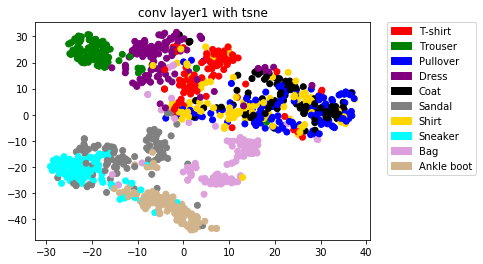

In [12]:
layer1_reshape = np.reshape(layer_to_visualize(convout1),[-1,28*28*96])
layer1_pca = pca(layer1_reshape, 50)
layer1_tsne = tsne(layer1_reshape, 2)
plot_scatter(layer1_tsne, test_label_index, "conv layer1 with tsne")

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


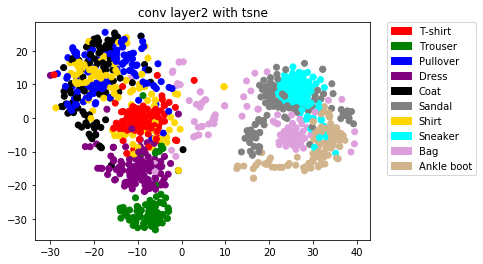

In [13]:
layer1_reshape = np.reshape(layer_to_visualize(convout2),[-1,28*28*96])
layer1_pca = pca(layer1_reshape, 50)
layer1_tsne = tsne(layer1_reshape, 2)
plot_scatter(layer1_tsne, test_label_index, "conv layer2 with tsne")

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


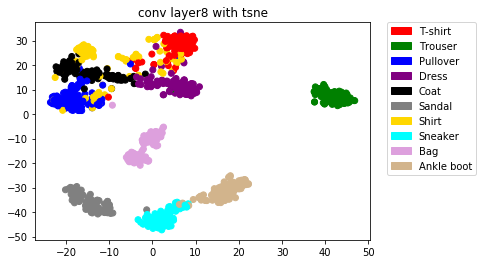

In [15]:
layer1_reshape = np.reshape(layer_to_visualize(convout8),[-1,5*5*192])
layer1_pca = pca(layer1_reshape, 50)
layer1_tsne = tsne(layer1_reshape, 2)
plot_scatter(layer1_tsne, test_label_index, "conv layer8 with tsne")

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


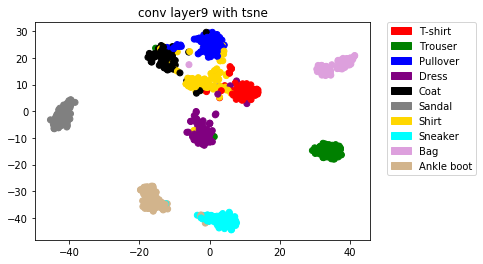

In [16]:
layer1_reshape = np.reshape(layer_to_visualize(convout9),[-1,5*5*10])
layer1_pca = pca(layer1_reshape, 50)
layer1_tsne = tsne(layer1_reshape, 2)
plot_scatter(layer1_tsne, test_label_index, "conv layer9 with tsne")

In [14]:
np.array(layer_to_visualize(convout8)).shape

(1000, 5, 5, 192)